## Science Data Analysis

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
%matplotlib widget

In [32]:
ls


HW1.ipynb                        correctAF87320.p
Untitled.ipynb                   correctAF87320err.p
aperture_photometry.ipynb        correctAF87321.p
bias/                            correctAF87321err.p
bias.ipynb                       correctAF87322.p
bias_stack.p                     correctAF87322err.p
centroid_measurement.ipynb       correctAF87323.p
correct/                         correctAF87323err.p
correctAF87314.p                 flat/
correctAF87314err.p              flat.ipynb
correctAF87315.p                 flat_normalization_factors.p
correctAF87315err.p              flat_normalized_stack.p
correctAF87316.p                 flat_stack.p
correctAF87316err.p              median_bias.p
correctAF87317.p                 median_bias_error.p
correctAF87317err.p              median_normalized_flat.p
correctAF87318.p                 median_normalized_flat_errors.p
correctAF87318err.p              science/
correctAF87319.p                 science_analysis.ipynb
correctAF87319err.p

In [33]:
science_list=np.genfromtxt("./science/science.list", dtype='str')

In [34]:
print(len(science_list))

1233


This is too many images for the computer, so we must do correction 'On the Fly', we save only the final outcome, and no intermediate data products. This is done on missions like PLATO (aperture photometry done on the satellite, only final data products are sent down. Happens with SMAP too!

We must check that we are doing things correctly on a small subsample (10-20 images)  then you do it for the hundreds or thousands of images. 

In [35]:
science_test_list=science_list[:10]
len(science_test_list)

10

In [36]:
median_bias=pickle.load(open('median_bias.p','rb'))
median_bias_error=pickle.load(open('median_bias_error.p','rb'))
median_normalized_flat=pickle.load(open('median_normalized_flat.p','rb'))
median_normalized_flat_error=pickle.load(open('median_normalized_flat_errors.p','rb'))

In [38]:
for science_name in science_test_list:
    science_fits=fits.open('science'+science_name)
    science_data=science_fits[0].data*science_fits[0].header['GAIN']
    science_fits.close()
    
    science_debiased=science_data-median_bias #the flux
    science_corrected=science_debiased/median_normalized_flat 
    #associated errors
    science_debiased_error=np.sqrt(science_fits[0].header['RDNOISE']**2+science_debiased+median_bias_error**2)
    science_corrected_error=science_corrected*np.sqrt((science_debiased_error/science_debiased)**2
                                                      +(median_normalized_flat_error/median_normalized_flat)**2)
    new_name = './correct/' + science_name[:-5] +'_corr.p'
    pickle.dump(science_corrected, open(new_name, 'wb'))
    new_name = './correct/' + science_name[:-5] +'_corr_errors.p'
    pickle.dump(science_corrected_error, open(new_name, 'wb'))

/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_81540/748991072.py:7: RuntimeWarning: divide by zero encountered in divide
  science_corrected=science_debiased/median_normalized_flat
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_81540/748991072.py:7: RuntimeWarning: invalid value encountered in divide
  science_corrected=science_debiased/median_normalized_flat
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_81540/748991072.py:10: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error=science_corrected*np.sqrt((science_debiased_error/science_debiased)**2
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_81540/748991072.py:11: RuntimeWarning: divide by zero encountered in divide
  +(median_normalized_flat_error/median_normalized_flat)**2)
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_81540/748991072.py:10: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error=science_corrected*np.sq

We get a runtime warning because the overscan has 0 values which get into the median_normalized flat. If we get this error anywhere else, we should investigate the source of the warning.

In [8]:
# in astronomy we use BJD_TDB - barycentric julian date of the dynamical time of the barycenter, so the reference is at the barycenter of the
# solar system and not the earth
# when you switch from UTC to BJD TDB you have to account for where we are in earth's orbit. delay can be up to 16 minutes so it's really important

In [39]:
# something may be missing here, check later with posted ipnyb files
# initializing empty arrays
n_images = len(science_test_list)
array_jd = np.zeros(n_images)
array_exptime = np.zeros(n_images)
array_airmass = np.zeros(n_images)

for i_science,science_name in enumerate(science_test_list):
    science_fits = fits.open('science/' + science_name)
    array_jd[i_science] = science_fits[0].header['JD']
    array_airmass[i_science] = science_fits[0].header['AIRMASS']
    array_exptime[i_science] = science_fits[0].header['EXPTIME']
    science_fits.close()
print(array_jd)
print(array_exptime)
print(array_airmass)

[2455630.447558 2455630.4477   2455630.447837 2455630.447974
 2455630.448111 2455630.448253 2455630.44839  2455630.448526
 2455630.448669 2455630.448811]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[1.216 1.216 1.215 1.215 1.214 1.214 1.213 1.213 1.212 1.212]


In [40]:
array_midexposure = array_jd + array_exptime/2./86400.
print(array_midexposure)

[2455630.44761587 2455630.44775787 2455630.44789487 2455630.44803187
 2455630.44816887 2455630.44831087 2455630.44844787 2455630.44858387
 2455630.44872687 2455630.44886887]


In [41]:
from astropy.time import Time
from astropy import coordinates as coord
from astropy import units as u

In [42]:
science_fits = fits.open('science/' + science_test_list[0])
print(science_fits[0].header['OBJCTRA'], science_fits[0].header['OBJCTDEC'])

13:57:33 +43:29:36


In [43]:
from astropy import coordinates as coord, units as u
target = coord.SkyCoord("20:13:31.61","+65:09:43.49", 
                        unit=(u.hourangle, u.deg), frame='icrs')

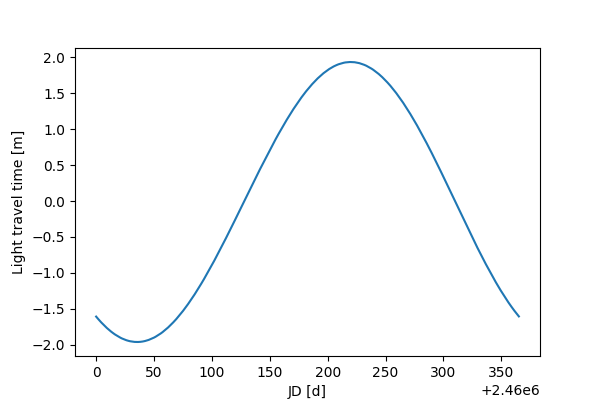

In [44]:
## install jplephem

from astropy.time import Time
#https://docs.astropy.org/en/stable/time/

# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target, ephemeris='jpl')  

# Convert to BJD_TDB, and then add the light travel time
bjd_tdb_plot = tm_plot.tdb + ltt_plot

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

In [45]:
telescope = coord.SkyCoord('13:57:24.93', '43:31:14', unit = (u.hourangle, u.deg), frame = 'icrs')
target = coord.SkyCoord('13:57:33', '+43:29:36', unit = (u.hourangle, u.deg), frame='icrs')
# icrs is international celestial reference system
# i can't run this right now so i can't copy the numbers into it
# check coordinates on simbad to be super safe, otherwise use coordinates of the object

In [46]:
# good time to check out the documentation for astropy - coords, time
telescope.ra.deg - target.ra.deg

-0.03362499999997226

In [47]:
# science_fits[0].header['SITELAT']
# science_fits[0].header['SITELONG']
time_object = Time(array_midexposure, format = 'jd', scale = 'utc', location = ('45.8472d','11.569d'))
# location is latitude and longitude of the telescope
# i copied his so don't use that, change it

In [48]:
mjd = array_jd - 2400000.5
print(science_fits[0].header['MJD']) # modified julian date - not really used anymore, but from the time when there were byte allocation limits
print(mjd[0])
# we don't need this part it's just here for intrigue?

55629.947558
55629.94755800022


In [49]:
bjd_tdb = time_object.tdb + time_object.light_travel_time(target, ephemeris = 'jpl')
# ephemeris: astronomical reference values for our target at a specific time
# those related to the earth at the specific julian date wrt barycenter
# jplephem is a missing package
# install with pip install --user jplephem into our conda environment
# running this may take time because it has to download ephemeris from jpl

In [50]:
print((bjd_tdb.value - array_midexposure)*86400)

[369.72456872 369.72476989 369.72501129 369.72521245 369.72545385
 369.72565502 369.72589642 369.72609758 369.72633898 369.72658038]


In [51]:
print((time_object.tdb.value - array_midexposure)*86400)

[66.18547887 66.18547887 66.18547887 66.18547887 66.18547887 66.18547887
 66.18547887 66.18547887 66.18547887 66.18547887]


In [52]:
jd_plot = np.arange(2460000.000, 2460365.25, 0.01)
time_plot = Time(jd_plot, format='jd', scale='utc', location = ('45.84848d','11.56900d'))
llt_target_plot = time_plot.light_travel_time(target, ephemeris='jpl')
llt_telescope_plot = time_plot.light_travel_time(telescope, ephemeris='jpl')

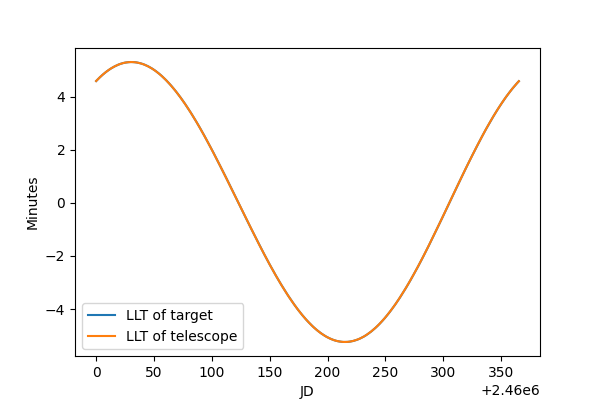

In [53]:
plt.figure(figsize=(6,4))
plt.plot(jd_plot, llt_target_plot.to_value(u.min), label='LLT of target')
plt.plot(jd_plot, llt_telescope_plot.to_value(u.min), label='LLT of telescope')
plt.legend()
plt.xlabel('JD')
plt.ylabel('Minutes')
plt.show()

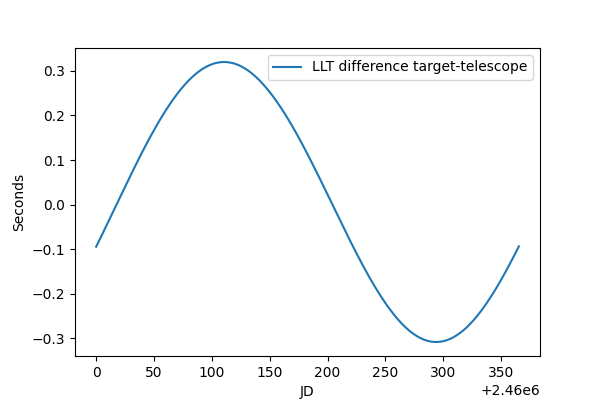

In [29]:
plt.figure(figsize=(6,4))
plt.plot(jd_plot, llt_target_plot.to_value(u.s)-llt_telescope_plot.to_value(u.s), label='LLT difference target-telescope')
plt.legend()
plt.xlabel('JD')
plt.ylabel('Seconds')
plt.show()
# the difference is small but increases and decreases over time

vmin: 531.84 vmax: 531.84 


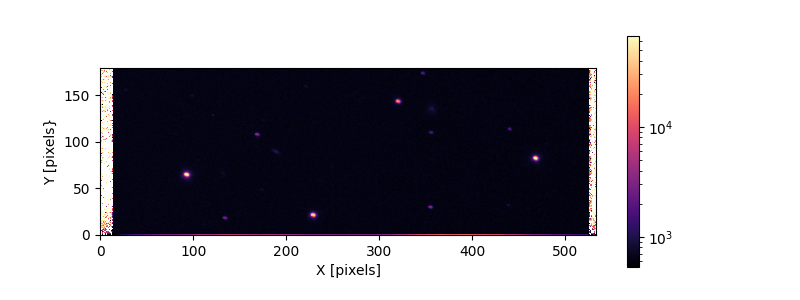

In [55]:
# identify target and reference star for aperture photography (?)
science_frame_name = './correct/' + science_test_list[-1][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name,'rb'))
import matplotlib.colors as colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin: {0:5.2f} vmax: {0:5.2f} '.format(vmin,vmax))

fig,ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin = 'lower')
# by changing the colors you can reproduce what you would see in ds9 because the color scale is logarithmic
plt.colorbar(im1, ax=ax)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels}')
plt.show()

In [ ]:
# go to simbad, find your target, identify your target in the field of view
# also check the rotation of the field to help you find the target and reference
# this is in the fits file under ROTANGLE